In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# image libraries
import cv2

In [2]:
tf.keras.__version__

'2.10.0'

In [3]:
# directories
# train_img_path = '/kaggle/input/cifake-real-and-ai-generated-synthetic-images/train'
# test_img_path = '/kaggle/input/cifake-real-and-ai-generated-synthetic-images/test'

train_img_path = 'artifact/train'
test_img_path = 'artifact/test'

w,h = 32,32
batch_size = 32

train_data_gen = ImageDataGenerator(
    rescale = 1.0/255
)
test_data_gen = ImageDataGenerator(rescale = 1.0/255)

train_Dataset = train_data_gen.flow_from_directory(
    train_img_path,
    target_size = (w,h),
    batch_size = batch_size,
    class_mode = 'binary',
    shuffle = True
)

test_Dataset = test_data_gen.flow_from_directory(
    test_img_path,
    target_size = (w,h),
    batch_size = batch_size,
    class_mode = 'binary',
    shuffle = False
)

Found 882752 images belonging to 2 classes.
Found 220694 images belonging to 2 classes.


In [4]:
train_Dataset.class_indices

{'FAKE': 0, 'REAL': 1}

In [5]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# CNN Model

In [6]:
# Define the model
model = models.Sequential()

# Convolutional layers
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(w, h, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Flatten layer
model.add(layers.Flatten())

# Dense layers
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))  # Optional dropout for regularization
model.add(layers.Dense(1, activation='sigmoid'))  # Output layer with 1 neuron (binary classification)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print a summary of the model architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 2, 2, 128)        0

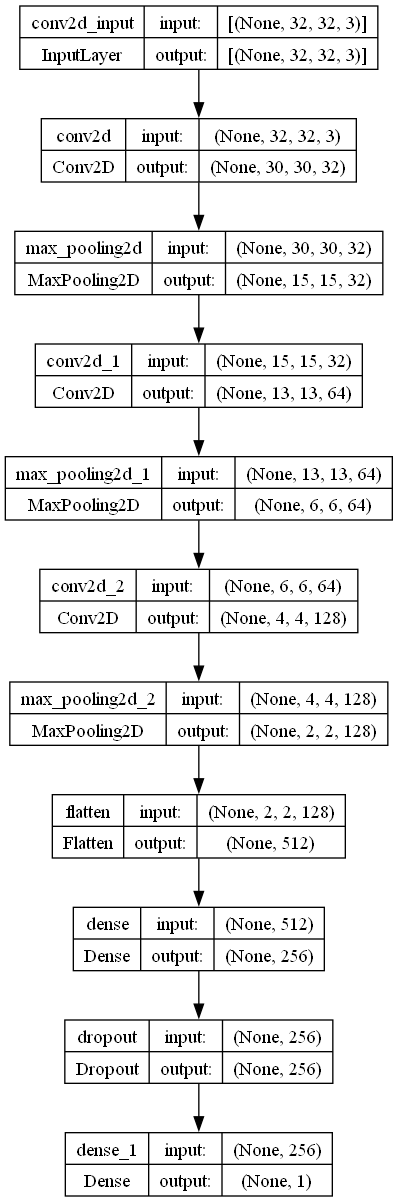

In [7]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True)


# Run Model



In [8]:
tf.config.list_physical_devices('GPU')


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [9]:
history = model.fit(train_Dataset, 
                    epochs=10, 
#                     callbacks=[model_checkpoint]
                   )

Epoch 1/10
27586/27586 [==============================] - 2621s 95ms/step - loss: 0.6162 - accuracy: 0.6425
Epoch 2/10
27586/27586 [==============================] - 574s 21ms/step - loss: 0.6014 - accuracy: 0.6554
Epoch 3/10
27586/27586 [==============================] - 558s 20ms/step - loss: 0.5956 - accuracy: 0.6604
Epoch 4/10
27586/27586 [==============================] - 563s 20ms/step - loss: 0.5924 - accuracy: 0.6639
Epoch 5/10
27586/27586 [==============================] - 526s 19ms/step - loss: 0.5901 - accuracy: 0.6653
Epoch 6/10
27586/27586 [==============================] - 495s 18ms/step - loss: 0.5884 - accuracy: 0.6661
Epoch 7/10
27586/27586 [==============================] - 469s 17ms/step - loss: 0.5866 - accuracy: 0.6685
Epoch 8/10
27586/27586 [==============================] - 417s 15ms/step - loss: 0.5862 - accuracy: 0.6692
Epoch 9/10
27586/27586 [==============================] - 524s 19ms/step - loss: 0.5852 - accuracy: 0.6699
Epoch 10/10
27586/27586 [===========

In [10]:
model.save_weights('./checkpoints/my_checkpoint')

In [11]:
model.save('my_model.keras')


In [12]:
model.save('my_model.h5')


In [13]:
# load best weights to model
# model.load_weights(weight_path)

# make prediction
predictions = model.predict(test_Dataset)
binary_predictions = (predictions > 0.5).astype(int)
binary_predictions

6897/6897 [==============================] - 696s 101ms/step


array([[0],
       [1],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [15]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(test_Dataset.classes, binary_predictions)
print(f'Accuracy: {accuracy*100:.2f}%')


Accuracy: 66.68%


In [16]:
from sklearn.metrics import confusion_matrix, classification_report

# Assuming you have true labels (ground truth)
true_labels = test_Dataset.classes

# Generate a confusion matrix
# sns.heatmap(confusion_matrix(true_labels, binary_predictions), annot=True)

# Print classification report
print(classification_report(true_labels, binary_predictions))

# plt.title('Confusion Matrix')
# plt.xlabel('Predicted')
# plt.ylabel('Actual Classes')
# plt.show()

              precision    recall  f1-score   support

           0       0.62      0.50      0.55     90962
           1       0.69      0.78      0.73    129732

    accuracy                           0.67    220694
   macro avg       0.65      0.64      0.64    220694
weighted avg       0.66      0.67      0.66    220694

